<style>
    @media print{
        body {
            position:relative !important;
        }
        .celltag_new_page {
            page-break-before: always !important;
        }
    }
</style>
# Metamaterial GBDT

In [51]:
import scipy.io
import numpy as np
from matplotlib import pyplot as plt

# Import data: dataset contains frequency data for 2D mechanical metamaterial designs
# The designs are made by 10*10 symmetric unit-cells that can be represented by 15 dimensional binary vector.
metamaterial_designs = scipy.io.loadmat('All_UCs_Connected_Nonsingular_CoarseDesign_Dispersion.mat')
print(metamaterial_designs.keys())

frequency_data = metamaterial_designs['FREQUENCY_DATA']
print(np.shape(frequency_data))

dict_keys(['__header__', '__version__', '__globals__', 'FREQUENCY_DATA', 'WAVEVECTOR_DATA', 'all_designs'])
(61, 40, 1577)


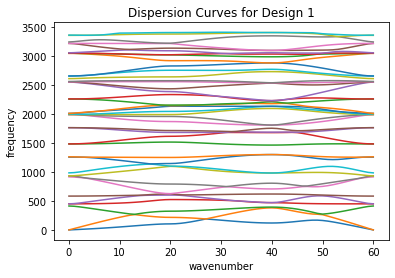

In [52]:
%%capture --no-display

# Plot dispersion curves from the frequency data of a specified design

DESIGN_NUM = 1 # 0 to 1576 designs
plt.title('Dispersion Curves for Design ' + str(DESIGN_NUM))
plt.xlabel('wavenumber')
plt.ylabel('frequency')
for x in range(np.size(frequency_data[0,:,0])):
    plt.plot(frequency_data[:,x,DESIGN_NUM], label="line" + str(x))

In [53]:
# Find the frequency ranges in which a bandgap occurs

GAP_THRESHOLD = 120

# store bandgaps from different designs as a list of list of tuples (lower frequency range, upper frequency range)
all_bandgap_data = []

# iterate through all the designs
for i in range(np.size(frequency_data[0,0,:])):
    curr_data = frequency_data[:,:,i]
    curr_design_bandgap = []
    
    # iterate through all dispersion curves
    for j in range(np.size(frequency_data[0,:,0])-1):
        lower_curve = max(curr_data[:,j])
        upper_curve = min(curr_data[:,j+1])
        
        # if there are no overlaps between the two curves and the difference is greater than the threshold
        if (lower_curve < upper_curve and upper_curve - lower_curve > GAP_THRESHOLD):
            bandgap_range = (lower_curve, upper_curve)
            curr_design_bandgap.append(bandgap_range)
            
    all_bandgap_data.append(curr_design_bandgap)

In [54]:
# Return 1 if the design has a bandgap within the input frequency range and 0 if not
# design_bandgaps: contains bandgaps as list of tuples (lower frequency range, upper frequency range) for a design
# frequency range: tuple containing the input lower and upper frequency range
# inclusive for the input lower frequency range and exclusive for the upper frequency range
def bandgaps_in_range(design_bandgaps, frequency_range):
    lower_bound = frequency_range[0]
    upper_bound = frequency_range[1]
    for bandgap_range in design_bandgaps:
        if lower_bound <= bandgap_range[0] <= upper_bound:
            return 1
        if lower_bound <= bandgap_range[1] <= upper_bound:
            return 1
    return 0

In [55]:
# Label the bandgap data for a given input frequency range

bandgap_labels = np.zeros(len(all_bandgap_data))
FREQ_RANGE = (400, 600)
for k in range(len(all_bandgap_data)):
    bandgap_labels[k] = bandgaps_in_range(all_bandgap_data[k], FREQ_RANGE)

# Count how many bandgaps exist in the given input frequency range
count = 0
for label in bandgap_labels:
    if label == 1:
        count += 1
print(count)

88


In [56]:
from sklearn.ensemble import GradientBoostingClassifier
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

# Train a Gradient Boosted Decision Trees model
# to try to predict if a design has a bandgap within a given frequency range.
# Return the score of the model for the training data and test data
def model_training(X, y, n_trees, test_proportion):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_proportion)
    model = GradientBoostingClassifier(
        max_depth=6,
        n_estimators=n_trees,
        learning_rate=1.0
    )
    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)

    score_tr = model.score(X_train, y_train)
    score_te = model.score(X_test, y_test)
#     print('Accuracy Score: ', score_te)
#     print(classification_report(y_test, y_pred))
    return score_tr, score_te

In [57]:
# Experiment with different training set data split percentage.

X = metamaterial_designs['all_designs']
y = bandgap_labels
n_trees = 3
n_trials = 1000

# 20% training data
test_proportion = 0.8
avg_score_20 = 0
for i in range(n_trials):
    avg_score_20 += model_training(X, y, n_trees, test_proportion)[1]
print('Average Accuracy Score for 20% Training Split: ', avg_score_20/n_trials)

# 40% training data
test_proportion = 0.6
avg_score_40 = 0
for i in range(n_trials):
    avg_score_40 += model_training(X, y, n_trees, test_proportion)[1]
print('Average Accuracy Score for 40% Training Split: ', avg_score_40/n_trials)

# 60% training data
test_proportion = 0.4
avg_score_60 = 0
for i in range(n_trials):
    avg_score_60 += model_training(X, y, n_trees, test_proportion)[1]
print('Average Accuracy Score for 60% Training Split: ', avg_score_60/n_trials)

# 80% training data
test_proportion = 0.2
avg_score_80 = 0
for i in range(n_trials):
    avg_score_80 += model_training(X, y, n_trees, test_proportion)[1]
print('Average Accuracy Score for 80% Training Split: ', avg_score_80/n_trials)


Average Accuracy Score for 20% Training Split:  0.8976616481774938
Average Accuracy Score for 40% Training Split:  0.9081309398099259
Average Accuracy Score for 60% Training Split:  0.9164706814579954
Average Accuracy Score for 80% Training Split:  0.9248639240506353


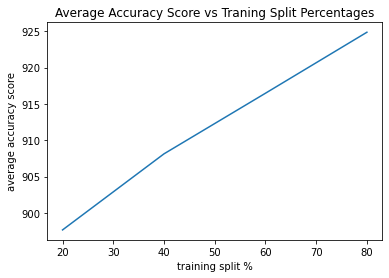

In [58]:
x_plot = [20, 40, 60, 80]
y_plot = [avg_score_20, avg_score_40, avg_score_60, avg_score_80]
plt.title('Average Accuracy Score vs Traning Split Percentages')
plt.ylabel('average accuracy score')
plt.xlabel('training split %')
plt.plot(x_plot, y_plot)